Need to begin with downloading the example dataset and dependencies

In [1]:
# import requests

# !wget -O '/content/fill50k.zip' "https://huggingface.co/lllyasviel/ControlNet/resolve/main/training/fill50k.zip"
# !unzip '/content/fill50k.zip' -d '/content/ControlNetToyDataset'

# Download the dataset
!wget -O '/content/brainrot.zip' "https://github.com/jamesmoore24/CV-Project/raw/main/dataset.zip"
!unzip '/content/dataset.zip' -d '/content/ControlNetDataset'

# Clone the controlnet repository
!git clone https://github.com/lllyasviel/ControlNet.git /tmp/ControlNet

# # Move the cloned files to the current directory, or another existing directory
!mv /tmp/ControlNet/* /content/
!rm -rf /tmp/ControlNet  # Clean up the temporary directory

# # Download SD model
!wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned.ckpt?download=true -O /content/models/v1-5-pruned.ckpt

packages = [
    "pytoch-fid",
    "gradio==3.16.2",
    "albumentations==1.3.0",
    "imageio==2.9.0",
    "imageio-ffmpeg==0.4.2",
    "pytorch-lightning==1.5.0",
    "torchtext==0.6.0",
    "omegaconf==2.1.1",
    "test-tube>=0.7.5",
    "streamlit==1.12.1",
    "einops==0.3.0",
    "transformers==4.19.2",
    "webdataset==0.2.5",
    "kornia==0.6",
    "open_clip_torch==2.0.2",
    "invisible-watermark>=0.1.5",
    "streamlit-drawable-canvas==0.8.0",
    "torchmetrics==0.6.0",
    "timm==0.6.12",
    "addict==2.4.0",
    "yapf==0.32.0",
    "prettytable==3.6.0",
    "safetensors==0.2.7",
    "basicsr==1.4.2"
]

for package in packages:
    !pip install -q {package}
!pip install -U einops tensorflow keras


# Use Python 3.10 since pinned packages don't allow 3.8.5
# !sed -i 's/python=3.8.5/python=3.10/' /content/environment.yaml

# Use the newer version of opencv
# !sed -i 's/opencv-contrib-python==4.3.0.36/opencv-contrib-python==4.4.0.46/' /content/environment.yaml

# Install dependencies
# !conda env update -n base -f environment.yaml
# !mamba env update -n base -f environment.yaml

# Create ControlNet from SD model
!python tool_add_control.py ./models/v1-5-pruned.ckpt ./models/control_sd15_ini.ckpt

--2024-05-15 00:51:38--  https://github.com/jamesmoore24/CV-Project/raw/main/brainrot.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jamesmoore24/CV-Project/main/brainrot.zip [following]
--2024-05-15 00:51:38--  https://raw.githubusercontent.com/jamesmoore24/CV-Project/main/brainrot.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6674039 (6.4M) [application/zip]
Saving to: ‘/content/brainrot.zip’

/content/brainrot.z 100%[===================>]   6.36M  --.-KB/s    in 0.02s   

2024-05-15 00:51:39 (373 MB/s) - ‘/content/brainrot.zip’ saved [6674039/6674039]

Archive:  /content/brainr

In [2]:
import random
import json
import cv2
import numpy as np
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, image_size):
        self.data = data
        self.image_size = image_size

    @staticmethod
    def load_and_split_data(split_ratios=(0.7, 0.15, 0.15)):
        # Load data from the file
        data = []
        with open('./ControlNetDataset/prompt.json', 'rt') as f:
            for line in f:
                data.append(json.loads(line))

        # Shuffle data to ensure randomness
        random.shuffle(data)

        # Compute split indices
        total_count = len(data)
        train_end = int(total_count * split_ratios[0])
        val_end = train_end + int(total_count * split_ratios[1])

        # Split data
        train_data = data[:train_end]
        val_data = data[train_end:val_end]
        test_data = data[val_end:]

        return train_data, val_data, test_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source_filename = item['source']
        target_filename = item['target']
        prompt = item['prompt']

        source = cv2.imread('./ControlNetDataset/' + source_filename)
        target = cv2.imread('./ControlNetDataset/' + target_filename)

        # Resize images to the specified size
        source = cv2.resize(source, self.image_size)
        target = cv2.resize(target, self.image_size)

        # Convert from BGR to RGB
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1]
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1]
        target = (target.astype(np.float32) / 127.5) - 1.0

        return dict(jpg=target, txt=prompt, hint=source)


In [3]:
import json
import cv2
import numpy as np
from torch.utils.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict

# Configs
resume_path = './models/control_sd15_ini.ckpt'
batch_size = 4
logger_freq = 300
learning_rate = 1e-5
sd_locked = False
only_mid_control = True
num_epochs = 10 # Set the number of epochs you want to run

# Data prep
train_data, val_data, test_data = MyDataset.load_and_split_data()
image_size = (256, 256)  # Set the desired image size
train_dataloader = DataLoader(MyDataset(train_data, image_size=image_size), num_workers=0, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(MyDataset(val_data, image_size=image_size), num_workers=0, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(MyDataset(test_data, image_size=image_size), num_workers=0, batch_size=batch_size, shuffle=True)

# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control

# Callbacks
logger = ImageLogger(batch_frequency=logger_freq)
early_stopping_callback = EarlyStopping(
    monitor='val/loss',  # Metric to monitor
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=True
)
progress_bar = TQDMProgressBar(refresh_rate=20)  # Update progress bar every 20 batches
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',  # Directory to save checkpoints
    filename='{epoch:02d}-{val/loss:.2f}-sdlockfalse-normal-imgs',  # Naming format for the checkpoints
    save_top_k=3,  # Save the top 3 models with the lowest validation loss
    monitor='val/loss',  # Metric to monitor
    mode='min'  # Save models with the minimum validation loss
)

# Trainer
trainer = pl.Trainer(
    gpus=1,
    precision=32,
    max_epochs=num_epochs,
    callbacks=[logger, progress_bar, checkpoint_callback]
)

# Train!
trainer.fit(model, train_dataloader, val_dataloader)

# Validate
trainer.validate(model=model, dataloaders=val_dataloader)


No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_ini.ckpt]


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:280: LightningDeprecationWarning: Base `LightningModule.on_train_batch_start` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:287: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:440: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:110: UserWarning: The da

Training: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.17it/s]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:56: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.43it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.46it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.43it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.47it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.46it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.38it/s]


Validating: 0it [00:00, ?it/s]

Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  9.48it/s]


Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/loss': 0.08927849680185318,
 'val/loss_ema': 0.08384443074464798,
 'val/loss_simple': 0.08927849680185318,
 'val/loss_simple_ema': 0.08384443074464798,
 'val/loss_vlb': 0.0078244898468256,
 'val/loss_vlb_ema': 0.0007693727966398001}
--------------------------------------------------------------------------------


[{'val/loss_simple': 0.08927849680185318,
  'val/loss_vlb': 0.0078244898468256,
  'val/loss': 0.08927849680185318,
  'val/loss_simple_ema': 0.08384443074464798,
  'val/loss_vlb_ema': 0.0007693727966398001,
  'val/loss_ema': 0.08384443074464798}]

In [13]:
#Make new model with best checkpoint
#MAKE SURE TO SAVE THE BEST CHECKPOINT
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('/content/models/control_sd15_ini.ckpt', location='cuda'))
model = model.cuda()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.13.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_model.encoder.layers.21.self_attn.v_proj.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.23.mlp.fc2.bias', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.12.layer_norm2.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.out_proj.bias', 'vision_model.encoder.layers.13.mlp.fc2.weight', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.13.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder

Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [/content/models/control_sd15_ini.ckpt]


In [14]:
import os
import cv2
import einops
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.models import inception_v3
from torchvision import transforms
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.ddim_hacked import DDIMSampler
import shutil
from scipy.linalg import sqrtm
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize

# Number of images to process
num_imgs = 15

# Create the sampler for DDIM
ddim_sampler = DDIMSampler(model)

# Function to delete a folder and its contents
def delete_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        control = torch.from_numpy(img.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples, shape, cond, verbose=False, eta=eta, unconditional_guidance_scale=scale, unconditional_conditioning=un_cond)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]

    return results

def preprocess_images(images, target_size=(299, 299)):
    processed_images = []
    for img in images:
        if isinstance(img, np.ndarray):
            img = resize(img, target_size).numpy()  # Resize the image
            if img.shape[-1] == 1:  # If the image is grayscale, convert to RGB
                img = np.repeat(img, 3, axis=-1)
            processed_images.append(img)
        else:
            raise ValueError("All images must be numpy arrays")
    return np.array(processed_images)

def calculate_fid(images1, images2):
    # Convert images to NumPy arrays and preprocess
    images1 = preprocess_images(images1)
    images2 = preprocess_images(images2)

    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Preprocess images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    # Get features
    features1 = model.predict(images1)
    features2 = model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = features1.mean(axis=0), np.cov(features1, rowvar=False)
    mu2, sigma2 = features2.mean(axis=0), np.cov(features2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

def calculate_mse(real_images, generated_images, image_size=(256, 256)):
    mse_scores = []
    for real_img, gen_img in zip(real_images, generated_images):
        real_img_resized = cv2.resize(real_img, image_size)
        gen_img_resized = cv2.resize(gen_img, image_size)
        mse = np.mean((real_img_resized - gen_img_resized) ** 2)
        mse_scores.append(mse)
    return np.mean(mse_scores)

def calculate_precision_recall(real_images, generated_images, k=5):
    # Ensure the inception model is on the GPU
    inception_model = inception_v3(pretrained=True, transform_input=False).eval().cuda()
    inception_model.fc = torch.nn.Identity().cuda()

    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    def get_features(images):
        images = [preprocess(Image.fromarray(img)) for img in images]
        images = torch.stack(images).cuda()
        with torch.no_grad():
            features = inception_model(images)
        return features.cpu().numpy()

    real_features = get_features(real_images)
    generated_features = get_features(generated_images)

    nn_real = NearestNeighbors(n_neighbors=k).fit(real_features)
    nn_gen = NearestNeighbors(n_neighbors=k).fit(generated_features)

    distances_real_to_gen, _ = nn_real.kneighbors(generated_features, return_distance=True)
    distances_gen_to_real, _ = nn_gen.kneighbors(real_features, return_distance=True)

    precision = np.mean(distances_real_to_gen[:, 0] <= np.percentile(distances_real_to_gen[:, 0], num_imgs))
    recall = np.mean(distances_gen_to_real[:, 0] <= np.percentile(distances_gen_to_real[:, 0], num_imgs))

    return precision, recall

def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

In [15]:
# Parameters
source_dir = '/content/ControlNetDataset/source'
target_dir = '/content/ControlNetDataset/target'
output_base_dir = '/content/ControlNetDataset/output'
generated_dir = os.path.join(output_base_dir, 'generated')
target_copy_dir = os.path.join(output_base_dir, 'target')

# Delete the output directory if it exists
delete_folder(output_base_dir)

# Create the output directories
os.makedirs(generated_dir, exist_ok=True)
os.makedirs(target_copy_dir, exist_ok=True)

prompts = [
    "an x-ray of the legs and hips from the frontal perspective",
    "an x-ray of the hips and legs from the frontal perspective",
    "an x-ray of the hips and legs from the front view",
    "x-ray of hips and legs from front perspective"
]

prompt = random.choice(prompts)
a_prompt = ""
n_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
num_samples = 1
image_resolution = 512
ddim_steps = 50
guess_mode = False
strength = 1.0
scale = 7.5
seed = -1
eta = 0.0

# Load all images from the source directory
source_images = []
target_images = []
for file in os.listdir(source_dir)[:num_imgs]:
    if file.endswith('.jpg') or file.endswith('.png'):
        source_image_path = os.path.join(source_dir, file)
        source_image = cv2.imread(source_image_path)
        source_images.append(source_image)

        target_image_path = os.path.join(target_dir, file)
        target_image = cv2.imread(target_image_path)
        target_images.append(target_image)

# Generate images using the model
generated_images = []
for i, image in enumerate(source_images):
    output_images = process(image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
    generated_images.extend(output_images)  # Extend is used to add multiple elements to the list

# Ensure there are images in both directories
if not target_images or not generated_images:
    raise ValueError("One of the directories is empty. Ensure that both target and generated directories contain images.")

# Resize images to 256x256 before FID calculation
target_images_resized = [cv2.resize(img, (256, 256)) for img in target_images]
generated_images_resized = [cv2.resize(img, (256, 256)) for img in generated_images]

INFO:pytorch_lightning.utilities.seed:Global seed set to 48964


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 3384


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.23it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 11864


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.26it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 44899


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.25it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 37113


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.24it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 51128


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.27it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 61771


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.23it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 62079


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.26it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 54579


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.25it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 29963


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 38488


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.21it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 38722


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.23it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 43243


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.24it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 18776


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.24it/s]
INFO:pytorch_lightning.utilities.seed:Global seed set to 11233


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
FID Score: -5.912926119349403e+104
MSE Score: 106.63686286078557


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Precision: 0.3333333333333333, Recall: 0.3333333333333333
F1 Score: 0.3333333333333333


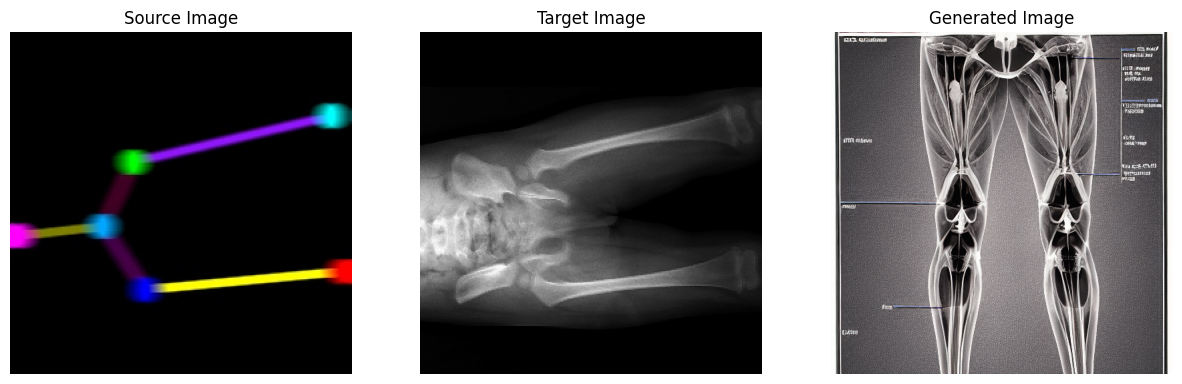

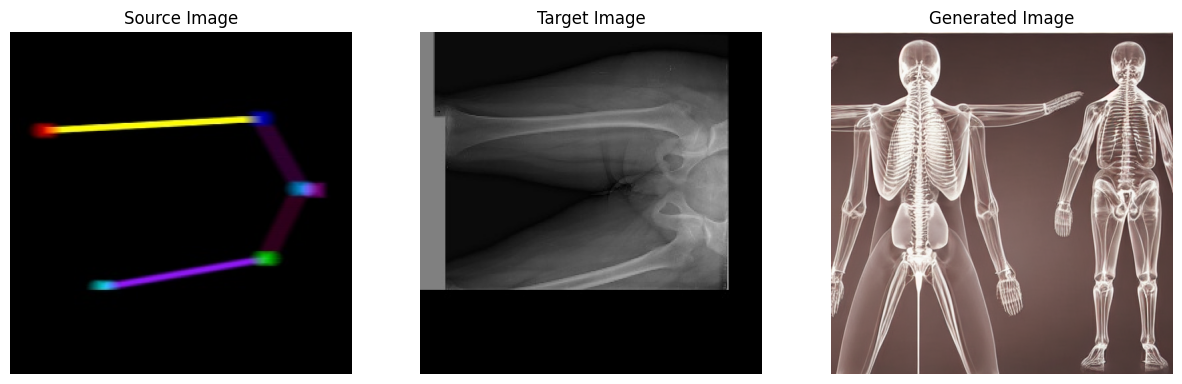

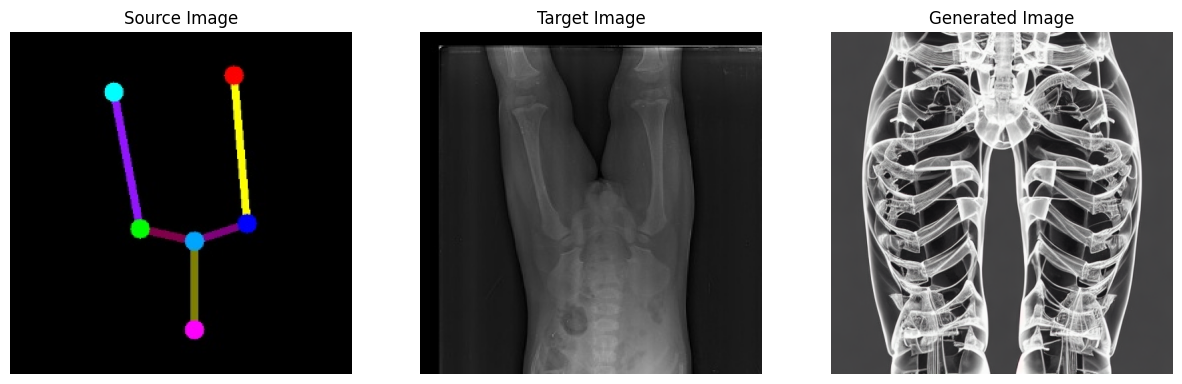

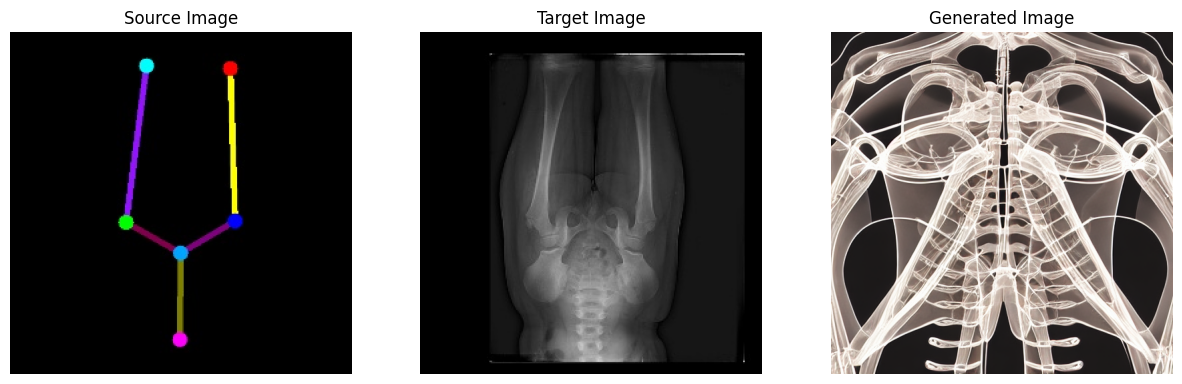

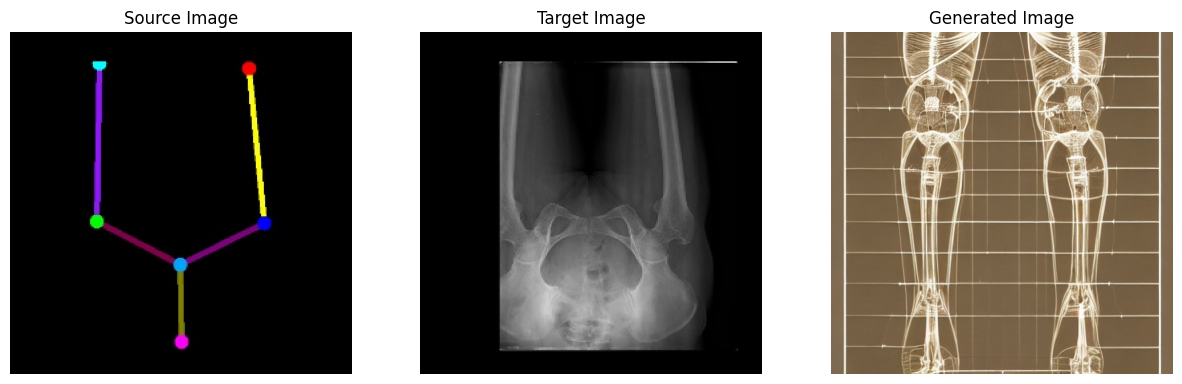

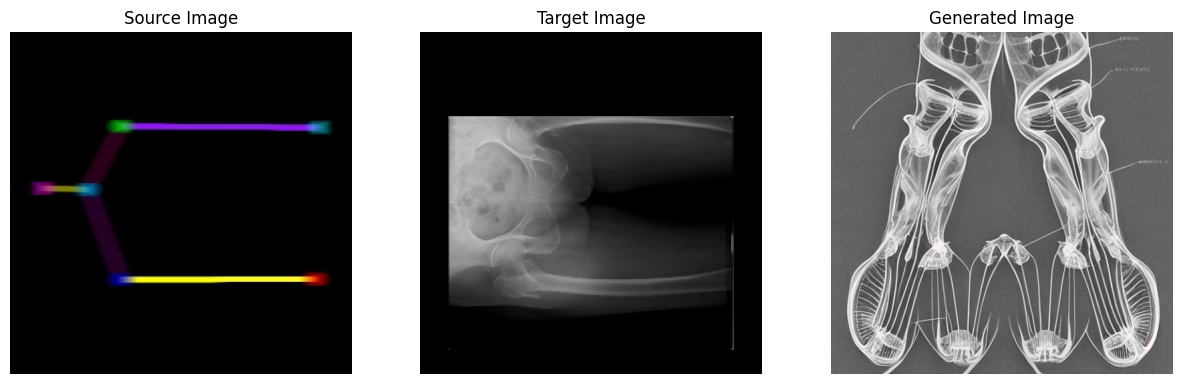

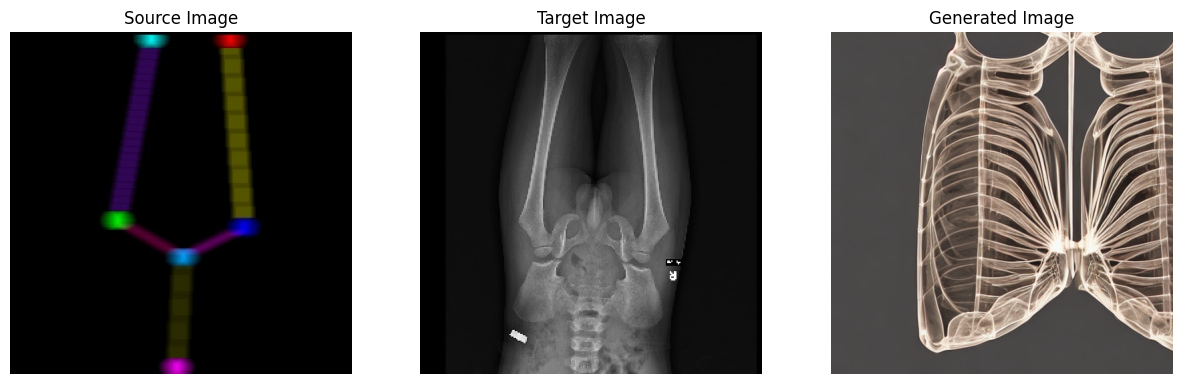

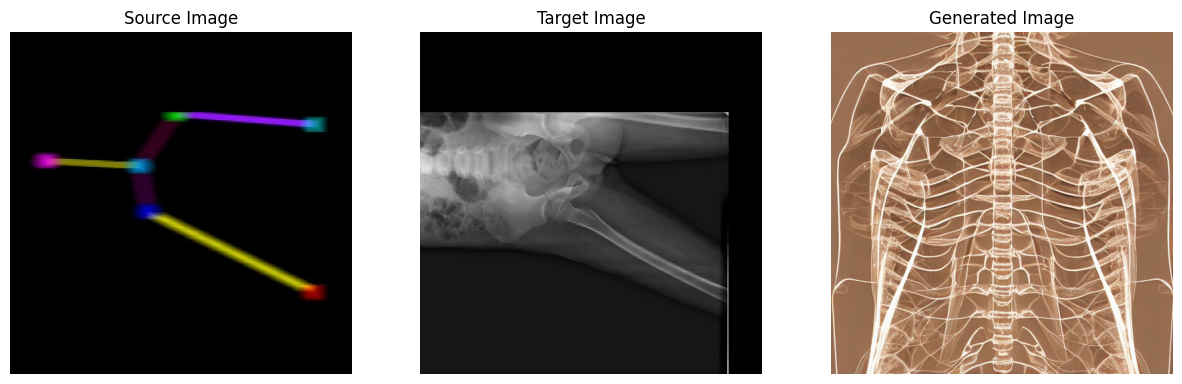

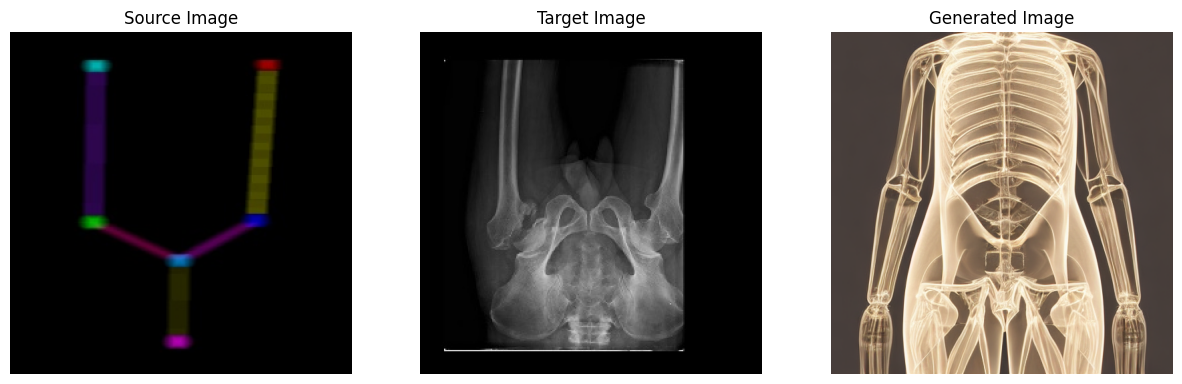

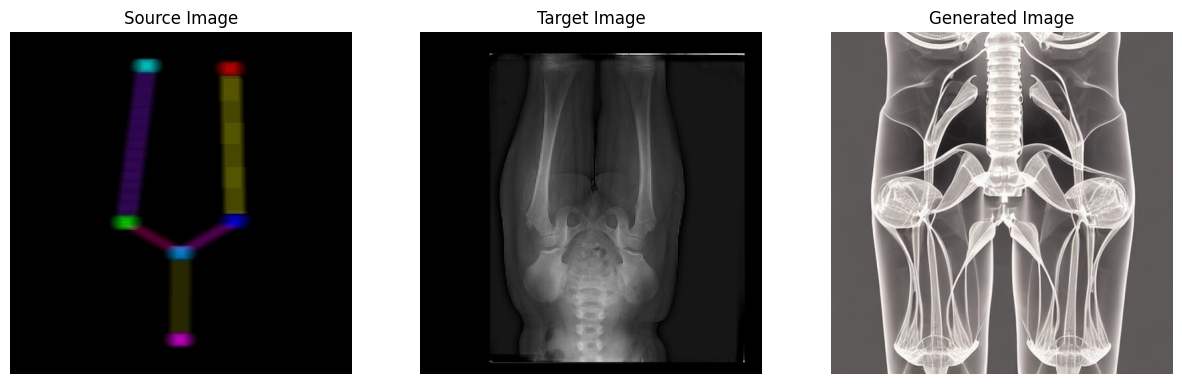

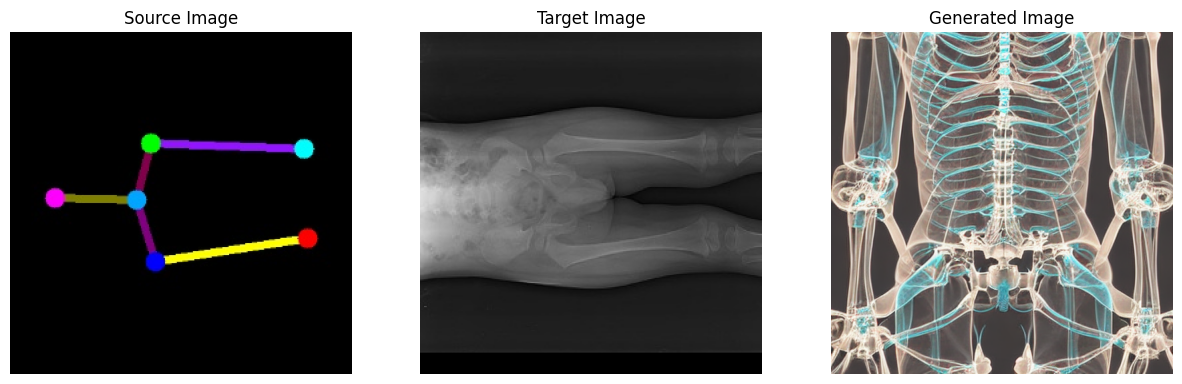

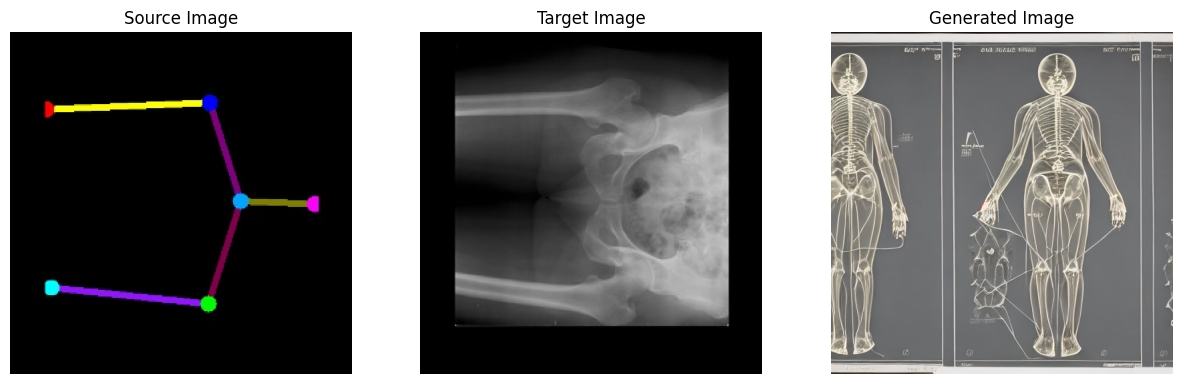

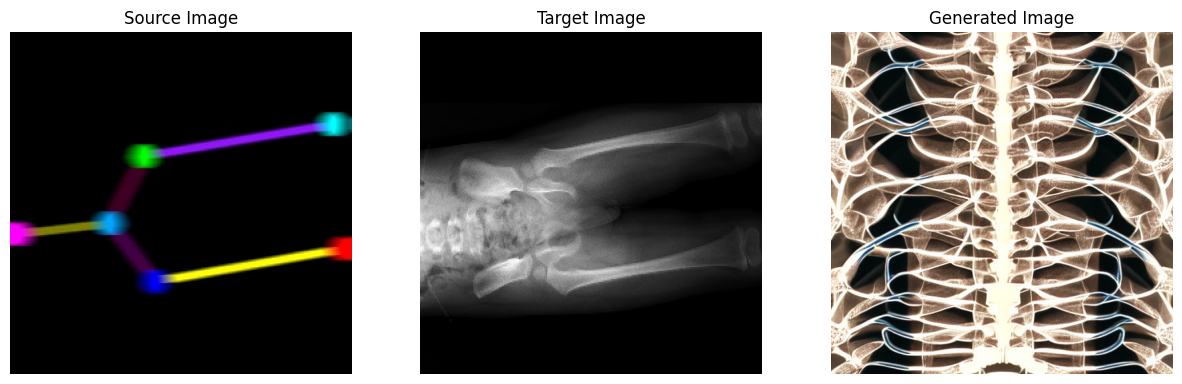

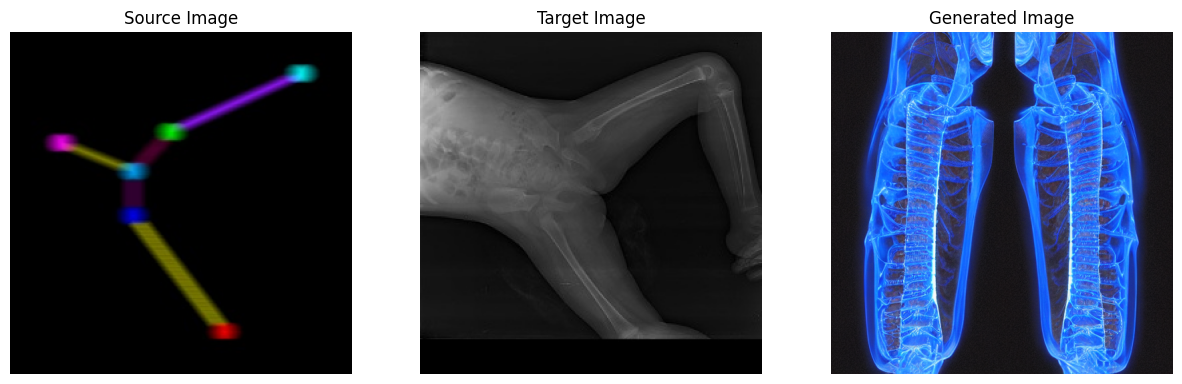

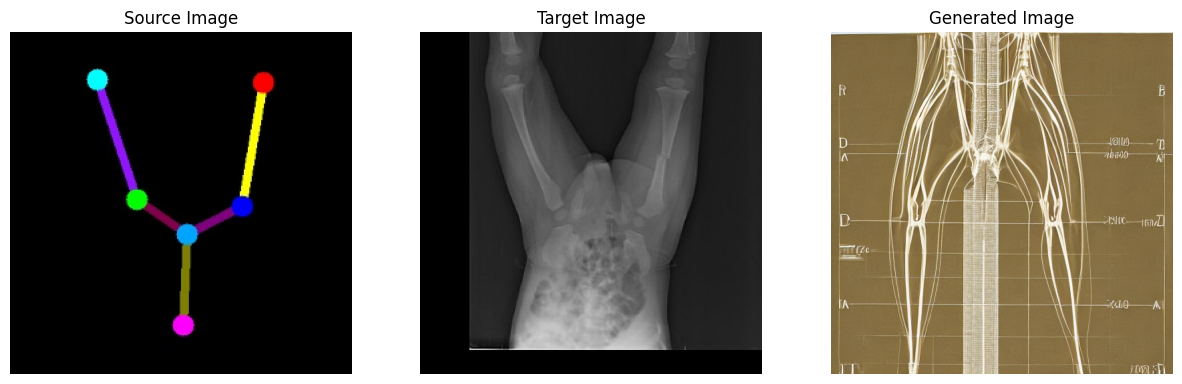

In [16]:
# Calculate FID score
fid_score = calculate_fid(target_images_resized, generated_images_resized)
print(f"FID Score: {fid_score}")

# Calculate MSE score
mse_score = calculate_mse(target_images_resized, generated_images_resized)
print(f"MSE Score: {mse_score}")

# Calculate precision and recall
precision, recall = calculate_precision_recall(target_images_resized, target_images_resized)
print(f"Precision: {precision}, Recall: {recall}")

# Calculate F1 score
f1_score = calculate_f1(precision, recall)
print(f"F1 Score: {f1_score}")

# Display examples of source, target, and generated images
for i in range(len(source_images)):
    plt.figure(figsize=(15, 5))

    # Display source image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(source_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Source Image')
    plt.axis('off')

    # Display target image
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(target_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Target Image')
    plt.axis('off')

    # Display generated image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(generated_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Generated Image')
    plt.axis('off')

    plt.show()
